In [43]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from scipy.special import expit
from scipy.optimize import fmin, minimize
from sklearn.metrics import mean_squared_error
from math import sqrt
import glob as glob
import matplotlib
matplotlib.style.use('ggplot')


In [7]:
all_dengue = pd.read_csv("all-dengues.csv")

all_dengue.index = pd.DatetimeIndex(all_dengue.date)
all_dengue = all_dengue.drop(['date','date.1'],axis=1)
all_dengues = all_dengue.resample('W').size()
all_dengues_df = pd.DataFrame(all_dengues,columns=['cases'])

In [8]:
def split_data(data):
    train_mask = (data.index < "2011")
    train = data[train_mask]
    test_mask = (data.index > "2011")
    test = data[test_mask]
    return train, test

def season(w,x):
#     thr_yr = 3*52
#     pi = np.math.pi
#     sine = np.math.sin((pi*x)/float(52))
#     return w[-2]*(sine) + w[-2]
    pi = np.math.pi
    coeff = pi/52.
    inside = coeff*(x + w[-2])
    cosine_sq = np.math.cos(inside)**2
    return (cosine_sq) + w[-3]

def theta(w,y):
    pad_y = np.concatenate(([1],np.array(y)))
    score = np.dot(w[:-3],pad_y)
    return expit(score)

def guess(w,x_week,y_case):
    return np.log(theta(w,y_case)+ 1e-5) + season(w,x_week) + w[-1] # w[-3] + season

In [36]:
def get_predictions(LAG, real, ws, nweeks_to_predict=[1]):

    def n_week_ahead(cases_for_prediction, weeks_ahead, case_week_to_predict):

        cur_prediction = 0
        prev_cases = np.array(cases_for_prediction.cases)
        for i in range(weeks_ahead):
            week_to_predict = case_week_to_predict + i
            cur_prediction = np.exp(guess(ws,i ,prev_cases))
            prev_cases = np.append(prev_cases[1:],cur_prediction) # deduct the first elm out
        return cur_prediction

    all_predictions = []
    for nweek in nweeks_to_predict: # 1,2,4,8,16
        predictions = []
        for start_week in range(len(real)-(LAG)):
            case_week_to_predict = start_week + LAG
            cases_for_prediction = real[start_week:case_week_to_predict]

            prediction = n_week_ahead(
                cases_for_prediction,
                nweek,
                case_week_to_predict)
            predictions.append(prediction)
        all_predictions.append(predictions)
    return all_predictions

In [28]:
def seperate_train_test(all_data,train_data):
    plt.axvspan(0, len(train_data), color='blue', alpha=0.1)
    plt.text((len(train_data)/2)-25,6000,'Train Period',size=16)
    plt.axvline(len(train_data)+1,linewidth=0.5, color='green')
    plt.text(len(train_data)+20,6000,'Test Period',size=16)
    plt.axvspan(len(train_data)+1, len(all_data), color='green', alpha=0.1)
    
def plot_all_predictions(LAG, train, real, nweeks_to_predict, all_predictions):
    
    plt.figure(figsize=(13,6))
    plt.plot(range(len(real)),real,label='real')
    graph_title = "Thailand Dengue Prediction"
    plt.title(graph_title)
    for i in range(len(all_predictions)):
        cur_week_guess = nweeks_to_predict[i]
        start_predict_week = LAG+(cur_week_guess-1)
        predicted_cases = all_predictions[i]
        x_weeks = range(start_predict_week,len(predicted_cases)+start_predict_week)
        line_label = "%d week guess"%cur_week_guess
        plt.plot(x_weeks,predicted_cases,label=line_label,alpha=0.8)
    
    seperate_train_test(real,train)
    plt.axvline(LAG)
    plt.text((LAG*2)+10,4000,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel("# week starting 2003")
    plt.ylabel("Dengue cases")
    plt.legend(loc='best')
#     plt.savefig("seasonal-logistic-thailand-dengue-cases-1-2-4.pdf")
    
def show_predictions(LAG, train, real, ws):
    predictions_to_plot = get_predictions(LAG, real, ws)
    plot_all_predictions(LAG, train, real, [1], predictions_to_plot)

In [16]:
# w_26 = [
#     -2.16205379e+00,  -1.64685281e-04,   1.45005627e-04,
#      1.56642794e-04,   1.09367152e-05,  -1.62093003e-04,
#      8.70904837e-05,  -1.18574268e-04,   1.00938620e-04,
#      1.21168605e-04,   1.69800703e-04,  -2.19839449e-05,
#     -7.02277995e-05,  -2.87743291e-04,   1.95540656e-04,
#      3.50862957e-04,  -2.74925455e-04,  -6.61755148e-05,
#      1.15202052e-04,   1.64032517e-04,   9.49332059e-05,
#     -7.38046523e-05,  -1.16076493e-04,  -3.17308306e-04,
#     -8.26561587e-06,   1.35321189e-04,   8.68061029e-04,
#     -1.38370313e-01,   2.16318750e+00,   7.86799725e+00
#      ]

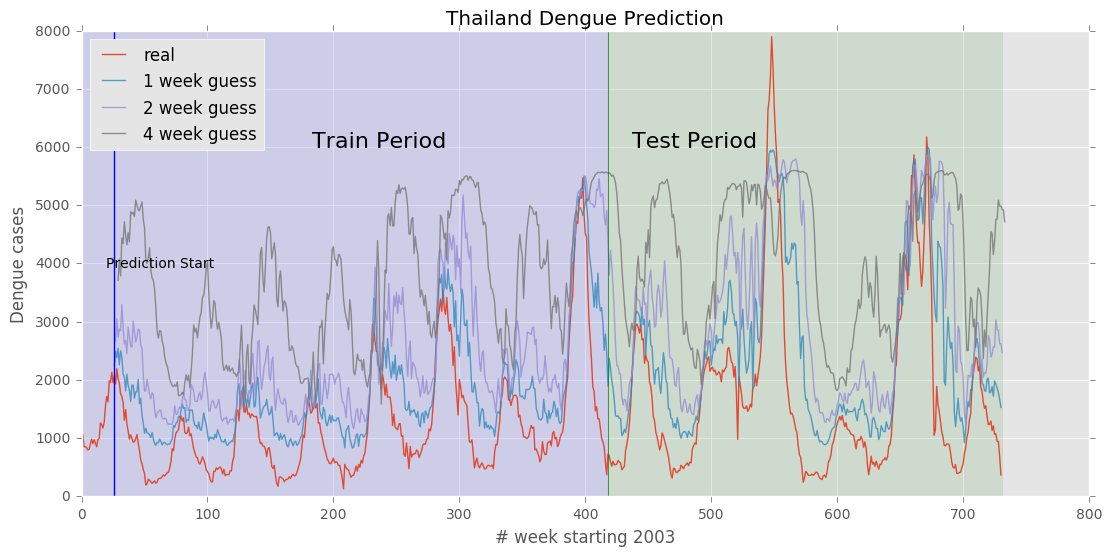

In [24]:
# a = get_predictions(27, all_dengues_df, w_27)
show_predictions(26, train, all_dengues_df, w_26)

In [37]:
# def get_distances(LAG, all_predictions, real):

#     def distance(prediction, real):
#         all_residual = prediction - real
#         return all_residual

#     weeks = [1]
#     ret = []
#     for idx,prediction in enumerate(all_predictions):
#         cur_pred = np.array(prediction)
#         # compare with real
#         # doesnt take into the accout of the predicted week(s)
#         cur_pred_range = cur_pred[:-weeks[idx]]
#         real_range = real.cases[LAG+weeks[idx]:]
#         ret.append(distance(cur_pred_range,real_range))

#     return ret

def get_distances(LAG, all_predicitions, real):
    np_all_pred = np.array(all_predicitions)
    np_real = np.array(real.cases[LAG:])
    res = np_real - np_all_pred
    return res

In [38]:
cur_ws = w_26
cur_train = train
cur_real = all_dengues_df
cur_test = test
    
predictions_to_validate = get_predictions(
        26,
        cur_test,
        cur_ws)
    
cur_test_err = get_distances(
        26,
        predictions_to_validate,
        cur_test)
    
test_err = cur_test_err

889.848056294
1393.03025439


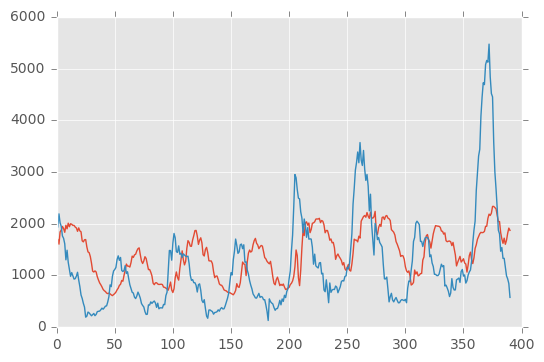

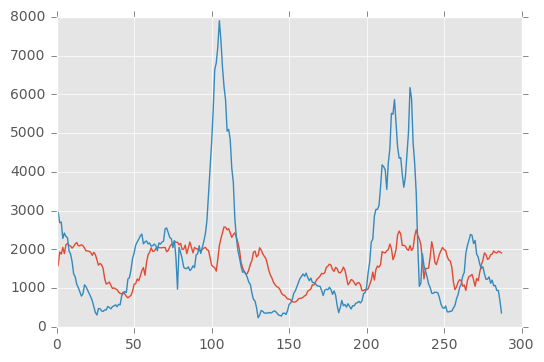

In [48]:
weeks_ahead = [16]
real_train = np.array(cur_train[26:])
real_test = np.array(cur_test[26:])

predictions_to_validate = get_predictions(
        26,
        cur_test,
        cur_ws,
        weeks_ahead)

train_to_validate = get_predictions(
        26,
        cur_train,
        cur_ws,
        weeks_ahead)

def RMSE(real, predicted):
    np_real, np_predicted = np.array(real), np.array(predicted)
    mse = mean_squared_error(np_real, np_predicted)
    score = sqrt(mse)
    return score

print RMSE(cur_train[26:],train_to_validate[0])
print RMSE(cur_test[26:],predictions_to_validate[0])

plt.plot(train_to_validate[0])
plt.plot(real_train)
plt.figure()

plt.plot(predictions_to_validate[0])
plt.plot(real_test)
# plt.xlim(285,290)
plt.figure()


In [39]:
def get_two_std_away(cur_predicted_weeks):
    cur_week_data = cur_predicted_weeks
    cur_week_mean = cur_week_data.mean()
    cur_week_std = cur_week_data.std()
    two_std = (cur_week_std*2)
    lower_bnd, upper_bnd = cur_week_mean - two_std, cur_week_mean + two_std
    cur_week_data_df = pd.DataFrame(cur_week_data)
    two_std_mask = (cur_week_data_df >= lower_bnd) & (cur_week_data_df <= upper_bnd)
    final_cur_week_data_df = pd.DataFrame(cur_week_data_df[two_std_mask])
    final_cur_week_data_df.columns = ['cases']
    final_cur_week_data_df = final_cur_week_data_df.dropna()
    return final_cur_week_data_df

0.920138888889


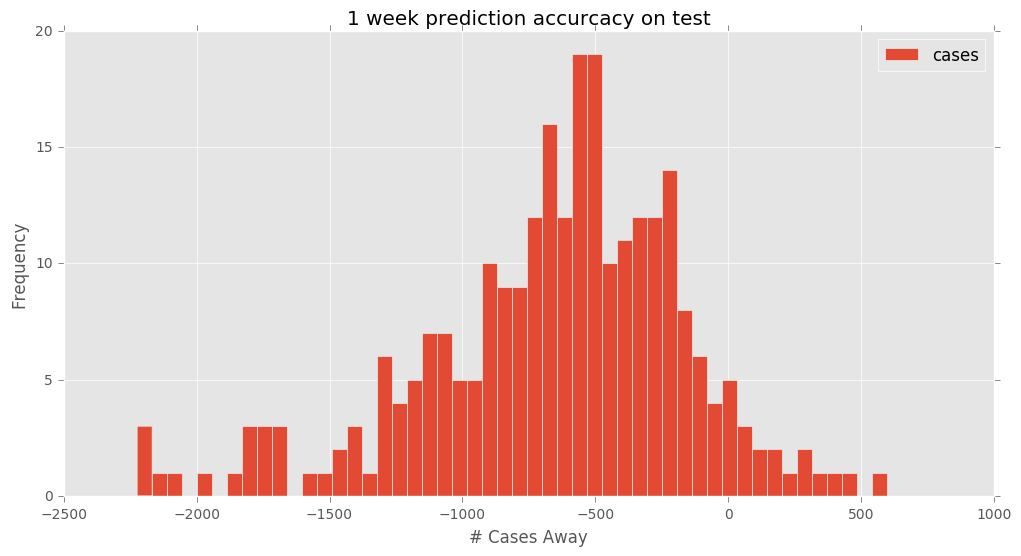

In [41]:
# weeks_predicted = [1,2,4,8,16]
# for idx, week in enumerate(weeks_predicted):
cur_distance_away_data = test_err[0]
two_std_away_data = get_two_std_away(cur_distance_away_data)

title = "1 week prediction accurcacy on test"
two_std_away_data.plot(kind="hist",bins=50,title=title,figsize=(12,6))
plt.xlabel("# Cases Away")
# plt.savefig("model-03-1-week-prediction-accuracy-test.pdf")
print len(two_std_away_data) / float(len(cur_distance_away_data))

## MAPE Mean Absolute Percentage Error

In [3]:
from sklearn.metrics import mean_squared_error
a = np.array(test[27:-2])
b = np.array(test_err[0])

np.sum(abs((a-b)))

NameError: name 'test' is not defined

In [126]:
print len(test[27:-2])
print len(test_err[0])

285
285
